# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

# formula api vs. array-based
import statsmodels.formula.api as smf



# Project Summary  

This project investigates where there is a causal relationship between the liberalization of divorce laws and wealth inequality as measured by the Gini index.

We conduct a staggered difference in difference analysis on observational data, with two way fixed effects (twfe) treatment. Since our data is observational, we consider the "treatment" event to be the passage of divorce laws. 

Analysis is conducted both with frequentist (t-test in statsmodels) and Bayesian approaches. The Bayes Factor gives us a principled way to assess causality, without requiring normality assumptions under null hypothesis, which ttest analysis requires. 

We have no reason to believe that Gini index would be normally distributed even under a null hypothesis, and some reasons to believe that it would be skewed. Thus, a Bayes Factor analysis may be more revealing.

Assigning a treatment group was more complicated than it seems. There are gradations of divorce:
- Illegal
- Legal but requiring proof of fault, such as infidelity, abuse, etc. "Irreconcilable" not allowed as reason.
- No Fault Lite: Allowing for "irretrievable breakdown" or "irreconcilable differences" as cited reason, rather than blame, but requiring proof of this status, and/or trial separation periods of varying length
- No Fault Mutual: Not requiring proof of status, but requiring mutual agreement for simplified process.
- No Fault Unilateral: All that is required is for one party to the marriage to say that it has broken down.

For the purposes of this study, we separate the various divorce categories into two main groups:
1) Group I: "irreconcilable differences" or "irretrievable breakdown" not recognized as grounds for divorce, or the process is fundamentally unfair ('favors men')
2) Group II: No fault is required, even if demonstrating that 'irreconcilable differences' or 'irretrievable breakdown' has occured


# Datasets and Dependencies

This causal analysis is complimentary to a parallel project, "Coresidence Analysis", which can be found in the same repository. For clarity, we refer to the previous predictive analysis as "CoResidence Analysis", versus "CoRes Causal" for the current project.

**Note that Gini values have been inverted to improve interpretability**

We heavily imputed CoResidence data to address missing values. In CoResidence Analysis, we pushed the limits of imputation to enable forecasting, which typically requires a balanced panel dataset.

In CoRes Causal, no significant amount of data will be imputed. Country weighting will be applied to compensate for countries with many more years of data than others. In the previous analysis, we addressed data imbalance through radical imputation. Not here.In CoRes Causal, no significant amount of data will be imputed. Country weighting will be applied to compensate for countries with many more years of data than others. In the previous analysis, we addressed data imbalance through radical imputation. Not here.

CoResidence involved "central log ratio" transformation of multiple groups of simplex columns. 

We kept both transformed and un-transformed columns.


Citation for Cross Reference

Countries Where Divorce Is Illegal 2025. World Population Review. Retrieved June 19, 2025, from https://worldpopulationreview.com/country-rankings/countries-where-divorce-is-illegal

Cited sources of citation
https://en.wikipedia.org/wiki/Divorce_law_by_country
https://www.nytimes.com/2023/11/04/world/asia/philippines-divorce-illegal-legislation.html
https://www.respicio.ph/features/guide-to-annulment-in-the-philippines-understanding-the-process-and-grounds-for-marriage-nullification


# CoResidence Data

CoResidence with all merges and imputed targets


In [2]:
# read in data

df_raw = pd.read_csv('./artifact/cores_full_merge.csv')
df_raw.shape

(7808, 159)

In [3]:
df = df_raw.copy()

In [4]:
# Columns with nulls in 
h_cols = df.columns[df.columns.str.startswith(('H', 'D', 'P'))]

df = df.dropna(subset=h_cols)

In [5]:
df.shape

(629, 159)

# Divorce Data

In [6]:
divorce_data = pd.read_csv('./divorce_table_final.csv', index_col=0)
divorce_data.head()

,Country,Blame Based,Fault Comment,Irreconcilable Differences,No Fault Comment,Treatment Y/N,Treatment Year,Unnamed: 8,Fault Based,Mutual No Fault,Unilateral No Fault
0,Afghanistan,1977.0,Fault required,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
1,Albania,2003.0,Fault required,2013.0,Favors men,No,NaN,NaN,NaN,NaN,NaN
2,Algeria,1984.0,Fault required,2005.0,Favors men,No,NaN,NaN,NaN,NaN,NaN
3,Angola,NaN,NaN,1975.0,No fault,Yes,1976.0,NaN,Yes,Yes,One year separation
4,Argentina,1987.0,Fault required,2015.0,No fault,Yes,2016.0,NaN,No,Yes,Yes


In [7]:
# convert "Treatment Y/N" to integer

divorce_data['Treatment'] = divorce_data['Treatment Y/N'].map({'Yes':1, 'No':0})

In [8]:
divorce_data[['Treatment Y/N', 'Treatment']]

,Treatment Y/N,Treatment
0,No,0
1,No,0
2,No,0
3,Yes,1
4,Yes,1
...,...,...
152,No,0
153,Yes,1
154,No,0
155,Yes,1


In [9]:
# check if any years are missing from treatment

mask = (divorce_data['Treatment'].eq(1) & divorce_data['Treatment Year'].isnull())
    
if mask.any():  
    print(f"Uh-oh, year missing for {divorce_data.loc[mask, 'Country'].to_list()}")
else:
    print('All good and tidy.')

All good and tidy.


In [10]:
# check if any untreated years have a date in the "Treatment Year" column by accident

mask = (divorce_data['Treatment Y/N']=='No') & (divorce_data['Treatment Year'].notnull())

if mask.any():
    print(f"Uh-oh, year missing for {divorce_data.loc[mask, 'Country'].to_list()}")
else:
    print('All good and tidy.')

All good and tidy.


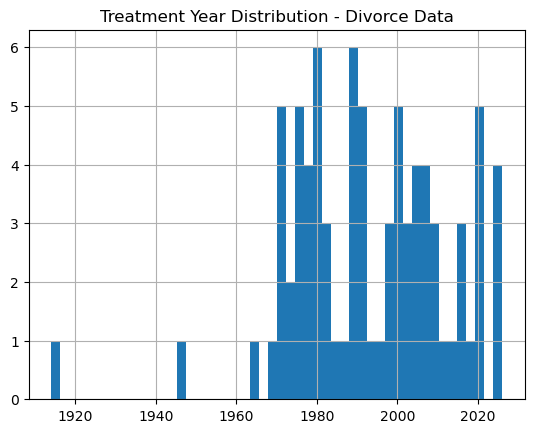

In [11]:
# visualize divorce year

divorce_data['Treatment Year'].hist(bins=50)
plt.title('Treatment Year Distribution - Divorce Data')
plt.show()

In [12]:
# examine distribution of cohorts in divorce data

print(divorce_data['Treatment Year'].notnull().sum()/len(divorce_data))
print(divorce_data['Treatment Year'].notnull().sum()/(divorce_data['Treatment Year'].notnull().sum()+divorce_data['Treatment Year'].isnull().sum()))



0.5159235668789809
0.5159235668789809


# Merge: CoResidence & Divorce Data

In [13]:
# anticipate merge failures

[country for country in df['Country Name'].unique() if country not in divorce_data['Country'].unique()]

['Congo, Dem. Rep.',
 'Czechia',
 'Egypt, Arab Rep.',
 'Gambia, The',
 'Iran, Islamic Rep.',
 'Korea, Rep.',
 'Lao PDR',
 'North Macedonia',
 'West Bank and Gaza',
 'Russian Federation',
 'Slovak Republic',
 'Venezuela, RB',
 'Viet Nam',
 'Yemen, Rep.']

In [14]:
# name mapper for improved merge:

country_name_mapper = {
    'Congo, Dem. Rep.':'Congo',
 'Czechia':'Czech Republic',
 'Egypt, Arab Rep.':'Egypt',
 'Gambia, The':'Gambia',
 'Iran, Islamic Rep.':'Iran',
 'Korea, Rep.':'South Korea',
 'Lao PDR':'Laos',
 'North Macedonia':'Macedonia',
 'West Bank and Gaza':'Palestine',
 'Russian Federation':'Russia',
 'Slovak Republic':'Slovakia',
 'Venezuela, RB':'Venezuela',
 'Viet Nam':'Vietnam',
 'Yemen, Rep.':'Yemen'
}

# reverse
country_name_mapper = {
    value:key for key, value in country_name_mapper.items()
}


In [15]:
# update names in right table to prepare for successful merge

divorce_data['Country'] = divorce_data['Country'].replace(country_name_mapper)


In [16]:
# merge with divorce data

df_mstr = df.merge(divorce_data, left_on='Country Name', right_on='Country', how='left')

In [17]:
df_mstr[df_mstr['Treatment Y/N'].isnull()]

,C1,T1,C2,C3,C4,HS01,HS02,HS03,HS04,HS05,...,Fault Comment,Irreconcilable Differences,No Fault Comment,Treatment Y/N,Treatment Year,Unnamed: 8,Fault Based,Mutual No Fault,Unilateral No Fault,Treatment


In [18]:
# drop columns
columns_to_drop = ['Unnamed: 8', 'Fault Based', 'Mutual No Fault', 'Unilateral No Fault']
df_mstr = df_mstr.drop(columns=columns_to_drop)

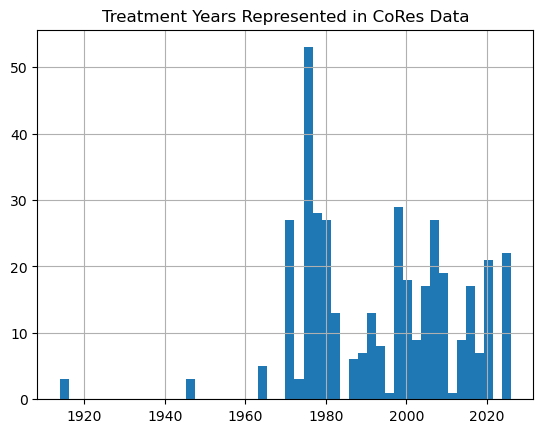

0.6248012718600954

In [19]:
# Plot treatment years represented in merged data

df_mstr['Treatment Year'].hist(bins=50)
plt.title('Treatment Years Represented in CoRes Data')
plt.show()

# size of treated vs. not treated, by year
df_mstr['Treatment Year'].notnull().sum()/len(df_mstr)

In [20]:
# create treatment cohorts

def treatment_cohort(treatment_year):
    """Takes treatment year and assigns to a cohort"""
    if pd.isna(treatment_year):
        return np.nan
    floor_decade = int((treatment_year)//10*10)
    ceiling_decade = floor_decade + 9
    treatment_cohort = f"{floor_decade}-{ceiling_decade}"
    return(treatment_cohort)
    

In [21]:
# create treatment cohorts using formula
df_mstr['Treatment Cohort'] = df_mstr['Treatment Year'].apply(lambda x: treatment_cohort(x))

In [41]:
# define viable cohorts as those having n>30

viable_cohorts = df_mstr['Treatment Cohort'].value_counts().loc[lambda x: x >=30].index
viable_cohorts = sorted(viable_cohorts)

In [42]:
# OnTreat column tracks which entities and years have received treatment

df_mstr['OnTreat'] = (
    (df_mstr['Year']>=df_mstr['Treatment Year']) 
    & df_mstr['Treatment'].eq(1)
).astype(int)


# Staggered DiD

In [46]:
# DiD

# initiate dictionaries to store results
results = {}
warn_log = {}
custom_summary = []

Y = 'Gini_recon_hybrid'
target = 'Treatment:OnTreat'

for cohort in viable_cohorts:
    treated_mask = df_mstr['Treatment Cohort']==cohort
    treated = df_mstr[treated_mask]
    print(cohort)
    
    benchmark_year = treated['Treatment Year'].mode().iat[0]
    
    # control groups:
    # never treated & not-yet-treated (where years come before treatment)
    never_treated_mask = df_mstr['Treatment']== 0
    not_yet_treated_mask = (df_mstr['Treatment Year'].gt(benchmark_year) 
                            & df_mstr['Year'].lt(df_mstr['Treatment Year']))
    control_mask = never_treated_mask | not_yet_treated_mask
                            
    subset = df_mstr.loc[treated_mask | control_mask].copy()
    
    # identify countries with fewer than 2 observations
    singleton_countries = subset['Country'].value_counts().loc[lambda x: x<2]
    
    # drop singleton countries
    subset = subset[~subset['Country'].isin(singleton_countries)].copy()
    
    # DiD formula
    formula = f"{Y} ~ Treatment:OnTreat + C(Year) + C(Country)"
    
    result = smf.ols(formula=formula, data=subset).fit(
        cov_type = 'cluster',
        cov_kwds = {'groups': subset['Country']}
    )
    
    results[cohort] = result
    
    # generate DiD stats
    coef = result.params.get(target, np.nan)
    se = result.bse.get(target, np.nan)
    tval = result.tvalues.get(target, np.nan)
    pval = result.pvalues.get(target, np.nan)
    
    # gather DiD stats
    custom_summary.append({
        "cohort" : cohort,
        "coef": coef,
        "se":se,
        "tval": tval,
        "pval": pval
    }
    )
    
    # collect warnings in warn_log
    if pd.isna(se):
        warn_log.setdefault(cohort, []).append("DiD SE is NaN")
    if se==0:
        warn_log.setdefault(cohort, []).append("DiD SE is zero")
    if not np.isfinite(se):
        warn_log.setdefault(cohort, []).append("DiD SE if infinite")
        
    
    # capture results and warnings in dictionaries
    results[cohort] = result
    


1970-1979
1980-1989
1990-1999
2000-2009
2010-2019
2020-2029


/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


In [47]:
custom_summary

[{'cohort': '1970-1979',
  'coef': 2.8889117494520664,
  'se': 0.5345636155427484,
  'tval': 5.404243134877262,
  'pval': 6.508261488643635e-08},
 {'cohort': '1980-1989',
  'coef': 1.213950984903365,
  'se': 0.40867545674181344,
  'tval': 2.970452384348336,
  'pval': 0.0029736149917607988},
 {'cohort': '1990-1999',
  'coef': 1.823349284265865,
  'se': 1.9423451181599938,
  'tval': 0.9387359986741929,
  'pval': 0.34786630594759493},
 {'cohort': '2000-2009',
  'coef': 0.5638941976544919,
  'se': 0.701118542193891,
  'tval': 0.8042779697281913,
  'pval': 0.42123645780859365},
 {'cohort': '2010-2019',
  'coef': -0.4754814781960799,
  'se': 0.5399946426269568,
  'tval': -0.8805299917105948,
  'pval': 0.37857226519026177},
 {'cohort': '2020-2029', 'coef': 0.0, 'se': 0.0, 'tval': nan, 'pval': nan}]

In [48]:
warn_log

{'2020-2029': ['DiD SE is zero']}

In [38]:
results['1970-1979'].bse

Intercept                  0.395955
C(Country)[T.Algeria]      0.374068
C(Country)[T.Argentina]    0.450521
C(Country)[T.Armenia]      0.354862
C(Country)[T.Australia]    0.408159
                             ...   
C(Year)[T.2018]            1.174476
C(Year)[T.2019]            0.706596
C(Year)[T.2020]            0.428090
C(Year)[T.2021]            0.578374
Treatment:OnTreat          0.439412
Length: 145, dtype: float64

In [83]:
# check for any nulls
model_vars = ['Treatment', 'OnTreat', 'Year', 'Country']

subset[model_vars].isna().sum()

Treatment         0
post_treatment    0
Year              0
Country           0
dtype: int64

In [70]:
# check for singular countries

singleton_countries = subset['Country'].value_counts().loc[lambda x: x==1]
len(singleton_countries)

11

In [69]:
# check for singular years

singleton_years = subset['Year'].value_counts().loc[lambda x: x==1]
len(singleton_years)

12

In [91]:

subset.groupby('Year')['Treatment'].nunique().loc[lambda x: x<2]

Year
1962    1
1964    1
1968    1
1969    1
1971    1
1972    1
1973    1
1974    1
1976    1
1979    1
1981    1
1982    1
1984    1
1986    1
1987    1
1988    1
1989    1
2020    1
Name: Treatment, dtype: int64